# MoCo

In [1]:
# %xmode minimal

from pathlib import Path
import os

os.environ["KERAS_BACKEND"] = "jax"
# os.environ["KERAS_BACKEND"] = "torch"
# os.environ["KERAS_BACKEND"] = "tensorflow"

# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # disable GPU devices
os.environ["TFDS_DATA_DIR"] = os.path.expanduser("~/tensorflow_datasets")  # default location of tfds database

# Turn off logging for TF
import logging
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import tensorflow as tf
import tensorflow_datasets as tfds
tf.get_logger().setLevel(logging.ERROR)

# import librosa
# import librosa.display
# from IPython.display import Audio

import numpy as np
from matplotlib import pyplot as plt

# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

import keras
from keras import layers, models, ops, losses, metrics
# from keras.applications import resnet, vgg16

# tf.config.experimental_run_functions_eagerly(True)
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

In [2]:
import dpmhm
# dpmhm.datasets.get_dataset_list()

from dpmhm.datasets import preprocessing, transformer, feature, utils, spectral_window_pipeline, spectral_pipeline
from dpmhm.models import simclr

workdir = Path(os.path.expanduser("~/tmp/dpmhm/MoCo"))
os.makedirs(workdir, exist_ok=True)

dbdir = Path(os.path.expanduser('~/Projects/HIASCI/Data/MetaTwins'))
os.makedirs(dbdir, exist_ok=True)

# dpmhm.datasets.query_parameters('Paderborn')

## Build a meta-dataset

First we load several datasets and extract spectrogram patches of fixed dimension `(128,128)`. This dimension is large enough to accomodate the random crop of shape `(64,64)` that will be created later by spec-augmentation. Also we skip the resampling step which will considerable slow down the loading of datasets, and take randomly the first `Nmax` elements to reduce the size of the final dataset.

In [3]:
n_fft = 1024  # number of frequency bins
Nmax = 2500  # maximum number of elements per dataset
shuffle_size = 10000

In [ ]:
ds_all = {}

foo = dpmhm.datasets.spectral_window_pipeline('DIRG', 51200, split='variation', channels=[], n_fft=n_fft)
# ds_all['DIRG'] = foo
ds_all['DIRG'] = utils.restore_cardinality(foo.shuffle(shuffle_size).take(Nmax))

foo = dpmhm.datasets.spectral_window_pipeline('Paderborn', 64000, split='healthy[:10%]+artificial[:10%]', channels=['vibration'], n_fft=n_fft)
# ds_all['Paderborn'] = foo
ds_all['Paderborn'] = utils.restore_cardinality(foo.shuffle(shuffle_size).take(Nmax))

foo = dpmhm.datasets.spectral_window_pipeline('Ottawa', 200000, split='all', channels=[], n_fft=n_fft)
# ds_all['Ottawa'] = foo
ds_all['Ottawa'] = utils.restore_cardinality(foo.shuffle(shuffle_size).take(Nmax))

foo = dpmhm.datasets.spectral_window_pipeline('Phmap2021', 10544, split='train[:50%]', channels=[], n_fft=n_fft)
# ds_all['Phmap2021'] = foo
ds_all['Phmap2021'] = utils.restore_cardinality(foo.shuffle(shuffle_size).take(Nmax))

# eles = list(foo.take(10).as_numpy_iterator())

# ds_size = 0
# for k, foo in ds_all.items():
#     print(k, int(foo.cardinality()))
#     ds_size += int(foo.cardinality())

In [ ]:
# Serialization for better performance.
# Note that this should be done before the random augmentation.

ds1, ds2, ds3, ds4 = ds_all['DIRG'], ds_all['Paderborn'], ds_all['Ottawa'], ds_all['Phmap2021']

ds0 = ds1.concatenate(ds2).concatenate(ds3).concatenate(ds4)

ds0.save(str(dbdir/'dataset'))

In [4]:
ds0 = tf.data.Dataset.load(str(dbdir/'dataset'))

window_shape = (64, 64)

dt = transformer.SpecAugmentTwins(
    ds0,
    output_shape=window_shape,
    crop_kwargs={'prob':0.5},
    flip_kwargs={'axis':-1, 'prob':0.5},
    blur_kwargs={'sigma':1., 'prob':0.},
    fade_kwargs={'prob':0},
).dataset.map(
    lambda y1, y2: (tf.transpose(y1, perm=(1,2,0)), tf.transpose(y2, perm=(1,2,0)))  # to channel-last
)

ds = tf.data.Dataset.zip(dt, utils.constant_dataset())

# ds = utils.restore_cardinality(ds, ds_size)
input_shape = ds.element_spec[0][0].shape

ds_size = int(dt.cardinality())
ds.element_spec

((TensorSpec(shape=(64, 64, 1), dtype=tf.float32, name=None),
  TensorSpec(shape=(64, 64, 1), dtype=tf.float32, name=None)),
 TensorSpec(shape=(), dtype=tf.float32, name=None))

In [5]:
# # Serialization may disable the random augmentation

# ds.save(str(workdir/'simclr_dataset'))
# ds = tf.data.Dataset.load(str(workdir/'simclr_dataset'))

## Base MoCo model


In [12]:
batch_size = 32

ds_train = ds.shuffle(ds_size, reshuffle_each_iteration=True)\
    .repeat()\
    .batch(batch_size, drop_remainder=True)\
    .prefetch(tf.data.AUTOTUNE)
# ds_val = ds_split['val'].batch(batch_size, drop_remainder=True)
# ds_test = ds_split['test'].batch(1, drop_remainder=True)

ds_train.element_spec

((TensorSpec(shape=(32, 64, 64, 1), dtype=tf.float32, name=None),
  TensorSpec(shape=(32, 64, 64, 1), dtype=tf.float32, name=None)),
 TensorSpec(shape=(32,), dtype=tf.float32, name=None))

In [13]:
# encoder_kwargs = dict(include_top=False, weights='imagenet', pooling='avg')
encoder_kwargs = dict(include_top=False, weights=None, pooling='avg')

# model = dpmhm.models.simclr.SimCLR(input_shape, name='VGG16', tau=0.1, encoder_kwargs=encoder_kwargs)
model = dpmhm.models.moco.MoCo(input_shape, name='VGG16', tau=0.1, encoder_kwargs=encoder_kwargs)

# model._encoder.trainable = True

model.compile(
    optimizer=keras.optimizers.Adam(),
)
cb_ema = dpmhm.models.moco.MoCo_Callback()

model.summary()

Model: "mo_co_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional_18 (Functional)      │ ?                      │    14,714,694 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ projector (Sequential)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ online (Sequential)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ online (Sequential)             │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,429,388 (112.26 MB)

 Trainable params: 14,714,694 (56.13 MB)

 Non-trainable params: 14,714,694 (56.13 MB)

In [14]:
hh = model.fit(ds_train,
               # validation_data=ds_val,
               callbacks=[cb_ema],
               steps_per_epoch=ds_size // batch_size,
               epochs=10)

# model.save(workdir/'moco_base.keras')

Need at least one array to stack.
Encountered an unexpected tracer. A function transformed by JAX had a side effect, allowing for a reference to an intermediate value with type float32[32,256] wrapped in a DynamicJaxprTracer to escape the scope of the transformation.
JAX transformations require that functions explicitly return their outputs, and disallow saving intermediate values to global state.
The function being traced when the value leaked was wrapped_fn at /mnt/cache/.cache/pypoetry/virtualenvs/dpmhm-yVS8YoI0-py3.11/lib/python3.11/site-packages/keras/src/backend/jax/core.py:153 traced for make_jaxpr.
To catch the leak earlier, try setting the environment variable JAX_CHECK_TRACER_LEAKS or using the `jax.checking_leaks` context manager.
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.UnexpectedTracerError


Epoch 1/10


Encountered an unexpected tracer. A function transformed by JAX had a side effect, allowing for a reference to an intermediate value with type float32[32,256] wrapped in a DynamicJaxprTracer to escape the scope of the transformation.
JAX transformations require that functions explicitly return their outputs, and disallow saving intermediate values to global state.
The function being traced when the value leaked was wrapped_fn at /mnt/cache/.cache/pypoetry/virtualenvs/dpmhm-yVS8YoI0-py3.11/lib/python3.11/site-packages/keras/src/backend/jax/core.py:153 traced for make_jaxpr.
To catch the leak earlier, try setting the environment variable JAX_CHECK_TRACER_LEAKS or using the `jax.checking_leaks` context manager.
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.UnexpectedTracerError


 16/312 ━━━━━━━━━━━━━━━━━━━━ 6:59 1s/step - loss: -22.1807


KeyboardInterrupt



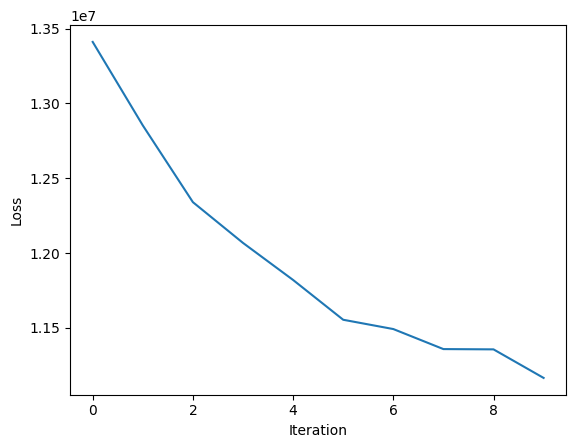

In [10]:
fig, ax = plt.subplots()
ax.plot(model.history.history['loss'])
ax.set_xlabel('Iteration')
ax.set_ylabel('Loss')
fig.savefig(workdir/'convergence.png')

From the trained SimCLR model, we extract the feature transformation part which includes the base encoder and the first two dense layers of the projection head. 

In [11]:
x = layers.Input(input_shape)

# same same
# _proj = models.Model(inputs=model._projector.inputs, outputs=model._projector.layers[3].output)
_proj = models.Model(inputs=model._projector.layers[0].input, outputs=model._projector.layers[3].output)

# _proj.summary()  # shows a concrete value for batch

f = _proj(model._encoder(x))

model_feature = models.Model(inputs=x, outputs=f, name='SimCLR_feature')

model_feature.summary()  # shows `None` for batch

# model_feature.save(str(workdir/'simclr_feature.keras'))

Model: "SimCLR_feature"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 128)            │     1,141,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_4 (Functional)       │ (None, 64)             │       410,944 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,552,320 (5.92 MB)

 Trainable params: 1,552,320 (5.92 MB)

 Non-trainable params: 0 (0.00 B)

## Transfer Learning

In [12]:
foo, full_labels_dict = _pipeline(
    'CWRU', 12000, split='all', 
    channels=[], 
    keys=['FaultLocation', 'FaultComponent', 'FaultSize'], 
    # keys=['FaultLocation'], 
    nf=nf, ws=64, labels=True
)

labels = list(full_labels_dict.keys())  
n_classes = len(labels) + 1

In [13]:
preproc = preprocessing.get_mapping_supervised(labels)

dw = utils.restore_cardinality(
    utils.restore_shape(
        foo.map(preproc, num_parallel_calls=tf.data.AUTOTUNE),
        key=0
    )
)

dw_size = int(dw.cardinality())

### Supervised training of the classification head

We add a classification head to the feature transformation network and fine tune the model on some new data.

In [14]:
splits = {'train':0.7, 'val':0.2, 'test':0.1}
batch_size = 32

dw_split = utils.split_dataset(
    dw, splits, 
    ds_size=dw_size, 
    # labels=np.arange(n_classes)
)

dw_train = dw_split['train']\
    .shuffle(dw_size, reshuffle_each_iteration=True)\
    .batch(batch_size, drop_remainder=True)\
    .prefetch(tf.data.AUTOTUNE)
dw_val = dw_split['val'].batch(batch_size, drop_remainder=True)
dw_test = dw_split['test'].batch(batch_size, drop_remainder=True)

The classification head here is a simple MLP. The weights of the feature transformation network are frozen for the training.

In [15]:
model_feature.trainable = False

class_head = models.Sequential([
    layers.Dense(128, activation='relu'),
    # layers.BatchNormalization(),
    layers.Dense(n_classes, activation=None) # nb labels
], name='Classification_head')

x = layers.Input(input_shape)

model_fine = models.Model(inputs=x, outputs=class_head(model_feature(x)))

model_fine.compile(
    optimizer=keras.optimizers.Adam(),
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[metrics.SparseCategoricalAccuracy()]
)

In [16]:
hh = model_fine.fit(
    dw_train,
    validation_data=dw_val,
    epochs=10
)

Epoch 1/10
1243/1243 ━━━━━━━━━━━━━━━━━━━━ 66s 39ms/step - loss: 3.2674 - sparse_categorical_accuracy: 0.0497 - val_loss: 3.1849 - val_sparse_categorical_accuracy: 0.0662
Epoch 2/10
1243/1243 ━━━━━━━━━━━━━━━━━━━━ 65s 38ms/step - loss: 3.1802 - sparse_categorical_accuracy: 0.0697 - val_loss: 3.1545 - val_sparse_categorical_accuracy: 0.0784
Epoch 3/10
1243/1243 ━━━━━━━━━━━━━━━━━━━━ 65s 39ms/step - loss: 3.1573 - sparse_categorical_accuracy: 0.0739 - val_loss: 3.1453 - val_sparse_categorical_accuracy: 0.0800
Epoch 4/10
1243/1243 ━━━━━━━━━━━━━━━━━━━━ 65s 38ms/step - loss: 3.1362 - sparse_categorical_accuracy: 0.0839 - val_loss: 3.1237 - val_sparse_categorical_accuracy: 0.0865
Epoch 5/10
1243/1243 ━━━━━━━━━━━━━━━━━━━━ 65s 38ms/step - loss: 3.1224 - sparse_categorical_accuracy: 0.0875 - val_loss: 3.1087 - val_sparse_categorical_accuracy: 0.0950
Epoch 6/10
1243/1243 ━━━━━━━━━━━━━━━━━━━━ 64s 38ms/step - loss: 3.1156 - sparse_categorical_accuracy: 0.0854 - val_loss: 3.1066 - val_sparse_categoric

In [17]:
model_fine.evaluate(dw_test)

177/177 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - loss: 3.0536 - sparse_categorical_accuracy: 0.1070


[3.0597851276397705, 0.10275423526763916]

#### Fine tuning

In [36]:
model_feature.trainable = True

model_fine.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[metrics.SparseCategoricalAccuracy()]
)

In [37]:
hh = model_fine.fit(
    dw_train,
    validation_data=dw_val,
    epochs=2
)

Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - loss: 4.6855 - sparse_categorical_accuracy: 0.0234 - val_loss: 3.5561 - val_sparse_categorical_accuracy: 0.0368
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - loss: 4.5819 - sparse_categorical_accuracy: 0.0189 - val_loss: 3.8871 - val_sparse_categorical_accuracy: 0.0402


In [38]:
model_fine.evaluate(dw_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 305ms/step - loss: 3.7828 - sparse_categorical_accuracy: 0.0330


[3.748819589614868, 0.0357142873108387]